In [1]:
from riskeye.utils.data import get_all_behavior, get_all_eyepos_info, get_all_subjects, Subject
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = get_all_behavior()

In [4]:
fixations = get_all_eyepos_info(source='saccades', summarize=False)

In [9]:
fixations = fixations[np.in1d(fixations['fixation_target'], ['left_option', 'right_option'])].droplevel('n')

KeyError: 'Level n not found'

In [134]:
def merge_fixations(d):
    d['previous_fixation_target'] = d['fixation_target'].shift(1)

    result = []

    n = 1
    duration = 0.0

    for ix, row in d.iterrows():
        if (row.fixation_target == row['previous_fixation_target']) or (pd.isnull(row.previous_fixation_target)):
            duration += row.duration
        else:
            result.append({'duration':duration, 'fixation_target':row.previous_fixation_target})
            duration = row.duration
            n += 1

    if duration != 0:
        result.append({'duration':duration, 'fixation_target':row.fixation_target})

    return pd.DataFrame(result, index=pd.Index(np.arange(1, n+1), name='n'))



In [135]:
saccades = saccades[np.in1d(saccades['fixation_target'], ['left_option', 'right_option'])].droplevel('n')

saccades = saccades.groupby(['subject', 'run', 'block', 'trial']).apply(merge_fixations)
# saccades['n'] = saccades.groupby(['subject', 'run', 'block', 'trial']).cumcount() + 1

In [136]:
saccades = saccades.join((df['p_left'] == 0.55).to_frame('risky_left'))

In [137]:
saccades['risky_left'] = saccades['risky_left'].astype(bool)

In [138]:
saccades['risky_fixation'] = ((saccades['fixation_target'] == 'left_option') & saccades['risky_left']) | ((saccades['fixation_target'] == 'right_option') & ~saccades['risky_left'])
saccades['left_fixation'] = saccades['fixation_target'] == 'left_option'

In [139]:
saccades

duration fixation_target  risky_left  \
subject run block trial n exptype                                          
01      1   1     1     1 symbolic     182.0     left_option        True   
                        2 symbolic     502.0    right_option        True   
                        3 symbolic     562.0     left_option        True   
                  2     1 symbolic     217.0    right_option        True   
                  3     1 symbolic     208.0     left_option        True   
...                                      ...             ...         ...   
64      5   4     23    1 symbolic     176.0     left_option       False   
                        2 symbolic     369.0    right_option       False   
                  24    1 symbolic     856.0     left_option       False   
                        2 symbolic     400.0    right_option       False   
                        3 symbolic     197.0     left_option       False   

                                    risky_fixation  left_fixation  
subject run block trial n exptype                                  
01      1   1     1     1 symbolic            True           True  
                        2 symbolic           False          False  
                        3 symbolic            True           True  
                  2     1 symbolic           False          False  
                  3     1 symbolic            True           True  
...                                            ...            ...  
64      5   4     23    1 symbolic           False           True  
                        2 symbolic            True          False  
                  24    1 symbolic           False           True  
                        2 symbolic            True          False  
                        3 symbolic           False           True  

[116703 rows x 5 columns]

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83412/3501425518.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = saccades.groupby(['subject', 'exptype', 'n']).mean()


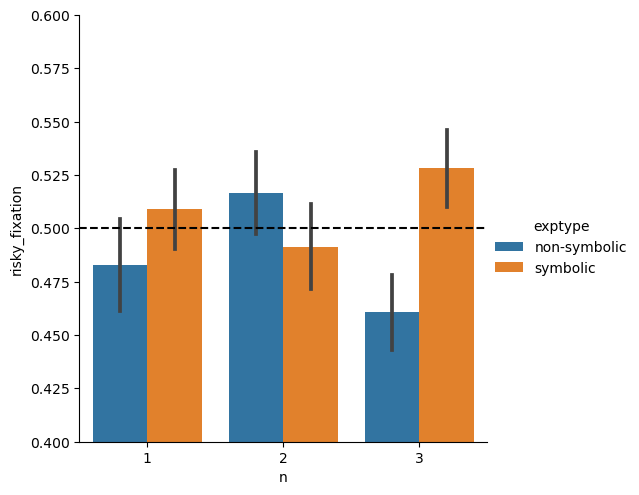

In [140]:
tmp = saccades.groupby(['subject', 'exptype', 'n']).mean()
sns.catplot(data=tmp.query('n < 4').reset_index(), x='n', y='risky_fixation', hue='exptype', kind='bar', errorbar='se')
plt.ylim(.4, .6)
plt.axhline(0.5, c='k', ls='--')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83412/3736851179.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = saccades.groupby(['subject', 'exptype', 'n']).mean()


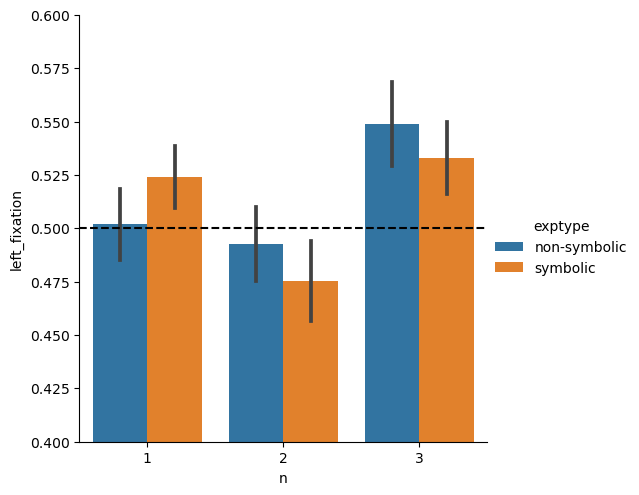

In [141]:
tmp = saccades.groupby(['subject', 'exptype', 'n']).mean()
sns.catplot(data=tmp.query('n < 4').reset_index(), x='n', y='left_fixation', hue='exptype', kind='bar', errorbar='se')
plt.ylim(.4, .6)
plt.axhline(0.5, c='k', ls='--')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83412/1060823331.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = saccades.groupby(['subject', 'exptype', 'n']).mean()


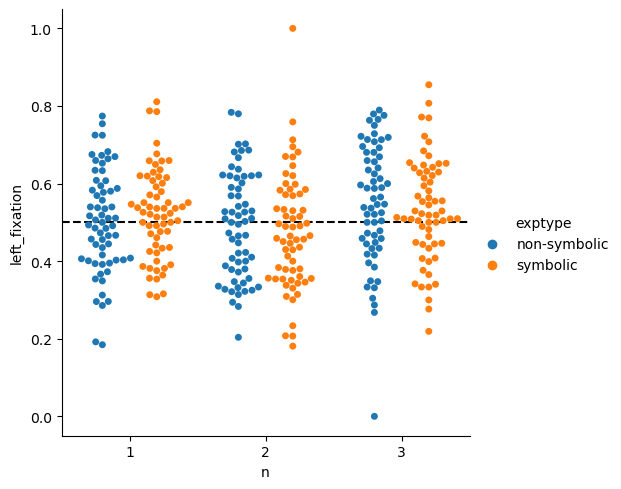

In [142]:
tmp = saccades.groupby(['subject', 'exptype', 'n']).mean()
sns.catplot(data=tmp.query('n < 4').reset_index(), x='n', y='left_fixation', hue='exptype', kind='swarm', errorbar='se', dodge=True)
# plt.ylim(.4, .6)
plt.axhline(0.5, c='k', ls='--')

In [143]:
df['EV_left'] = df['p_left'] * df['n_left']
df['EV_right'] = df['p_right'] * df['n_right']

In [144]:
# saccades = saccades.drop(['EV_left', 'EV_right', 'n_safe', 'n_risky', ], axis=1)

In [145]:
saccades = saccades.join(df[['EV_left', 'EV_right', 'n_safe', 'n_risky', 'n_left', 'n_right']])

In [146]:
saccades

duration fixation_target  risky_left  \
subject run block trial exptype  n                                         
01      1   1     1     symbolic 1     182.0     left_option        True   
                                 2     502.0    right_option        True   
                                 3     562.0     left_option        True   
                  2     symbolic 1     217.0    right_option        True   
                  3     symbolic 1     208.0     left_option        True   
...                                      ...             ...         ...   
64      5   4     23    symbolic 1     176.0     left_option       False   
                                 2     369.0    right_option       False   
                  24    symbolic 1     856.0     left_option       False   
                                 2     400.0    right_option       False   
                                 3     197.0     left_option       False   

                                    risky_fixation  left_fixation  EV_left  \
subject run block trial exptype  n                                           
01      1   1     1     symbolic 1            True           True    25.85   
                                 2           False          False    25.85   
                                 3            True           True    25.85   
                  2     symbolic 1           False          False     3.30   
                  3     symbolic 1            True           True     9.35   
...                                            ...            ...      ...   
64      5   4     23    symbolic 1           False           True    20.00   
                                 2            True          False    20.00   
                  24    symbolic 1           False           True    28.00   
                                 2            True          False    28.00   
                                 3           False           True    28.00   

                                    EV_right  n_safe  n_risky  n_left  n_right  
subject run block trial exptype  n                                              
01      1   1     1     symbolic 1     14.00    14.0     47.0    47.0     14.0  
                                 2     14.00    14.0     47.0    47.0     14.0  
                                 3     14.00    14.0     47.0    47.0     14.0  
                  2     symbolic 1      5.00     5.0      6.0     6.0      5.0  
                  3     symbolic 1     14.00    14.0     17.0    17.0     14.0  
...                                      ...     ...      ...     ...      ...  
64      5   4     23    symbolic 1     22.00    20.0     40.0    20.0     40.0  
                                 2     22.00    20.0     40.0    20.0     40.0  
                  24    symbolic 1     15.95    28.0     29.0    28.0     29.0  
                                 2     15.95    28.0     29.0    28.0     29.0  
                                 3     15.95    28.0     29.0    28.0     29.0  

[116703 rows x 11 columns]

In [150]:
saccades['EV_fixated'] = saccades['EV_left'].where(saccades['left_fixation'], saccades['EV_right'])
saccades['n_fixated'] = saccades['n_left'].where(saccades['left_fixation'], saccades['n_right'])

In [211]:
saccades['EV_risky'] = saccades['EV_left'].where(saccades['risky_left'], saccades['EV_right'])
saccades['EV_safe'] = saccades['EV_left'].where(~saccades['risky_left'], saccades['EV_right'])

In [255]:
saccades['log(risky/safe)'] = df['log(risky/safe)']

In [262]:
saccades = saccades.join(df['log(risky/safe)'])

In [265]:
saccades['bin(EV_fixated)'] = pd.cut(saccades['EV_fixated'], bins=np.arange(0, 120, 5))
saccades['bin(EV_fixated)'].cat.categories = [bin.mid for bin in saccades['bin(EV_fixated)'].cat.categories]

saccades['bin(EV_left)'] = pd.cut(saccades['EV_left'], bins=np.arange(0, 120, 5))
saccades['bin(EV_left)'].cat.categories = [bin.mid for bin in saccades['bin(EV_left)'].cat.categories]

saccades['bin(EV_risky)'] = pd.cut(saccades['EV_risky'], bins=np.arange(0, 120, 10))
saccades['bin(EV_risky)'].cat.categories = [bin.mid for bin in saccades['bin(EV_risky)'].cat.categories]

saccades['bin(log(risky/safe))'] = pd.qcut(saccades['log(risky/safe)'], q=7)
saccades['bin(log(risky/safe))'].cat.categories = [bin.mid for bin in saccades['bin(log(risky/safe))'].cat.categories]
# saccades['bin(EV_safe)'] = pd.cut(saccades['EV_safe'], bins=np.arange(0, 120, ))
# saccades['bin(EV_safe)'].cat.categories = [bin.mid for bin in saccades['bin(EV_safe)'].cat.categories]

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83412/3524074494.py:2: FutureWarning: Setting categories in-place is deprecated and will raise in a future version. Use rename_categories instead.
  saccades['bin(EV_fixated)'].cat.categories = [bin.mid for bin in saccades['bin(EV_fixated)'].cat.categories]
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83412/3524074494.py:5: FutureWarning: Setting categories in-place is deprecated and will raise in a future version. Use rename_categories instead.
  saccades['bin(EV_left)'].cat.categories = [bin.mid for bin in saccades['bin(EV_left)'].cat.categories]
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83412/3524074494.py:8: FutureWarning: Setting categories in-place is deprecated and will raise in a future version. Use rename_categories instead.
  saccades['bin(EV_risky)'].cat.categories = [bin.mid for bin in saccades['bin(EV_risky)'].cat.categories]
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83412/2511024901.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = saccades.groupby(['subject', 'bin(EV_risky)', 'n', 'exptype']).mean()
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83412/2511024901.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  tmp = tmp[~tmp.isnull().any(1)]
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83412/2511024901.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = saccades.groupby(['subject', 'EV_safe', 'n', '

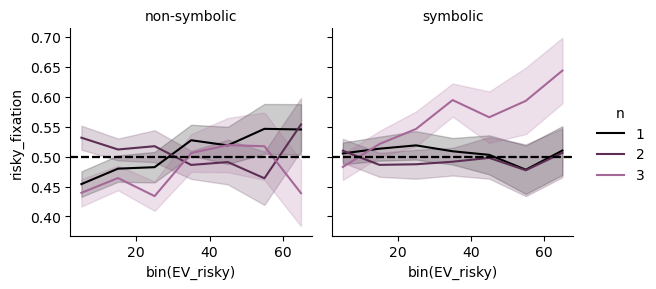

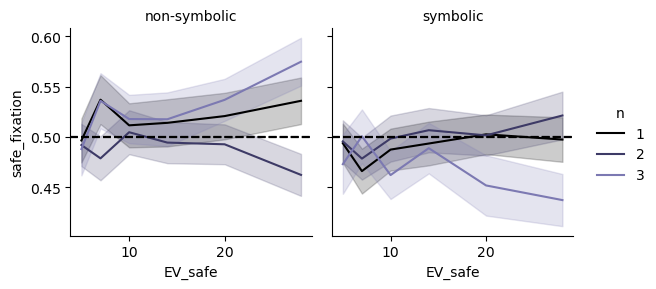

In [275]:
tmp = saccades.groupby(['subject', 'bin(EV_risky)', 'n', 'exptype']).mean()
tmp = tmp[~tmp.isnull().any(1)]

palette = sns.cubehelix_palette(start=.5, rot=0, dark=0, light=.5, n_colors=3, reverse=True)

g = sns.FacetGrid(tmp.query('(n < 4)').reset_index(), col='exptype', hue='n', palette=palette)#, palette='coolwarm')
g.map(sns.lineplot, 'bin(EV_risky)', 'risky_fixation', errorbar='se')
g.add_legend()
g.set_titles('{col_name}')
g.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))

tmp = saccades.groupby(['subject', 'EV_safe', 'n', 'exptype']).mean()
palette = sns.cubehelix_palette(start=0, rot=0, dark=0, light=.5, n_colors=3, reverse=True)
g = sns.FacetGrid(tmp.query('(n < 4)').reset_index(), col='exptype', hue='n', palette=palette)#, palette='coolwarm')
g.map(sns.lineplot, 'EV_safe', 'safe_fixation', errorbar='se')
g.add_legend()
g.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))
g.set_titles('{col_name}')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83412/74451552.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = saccades.groupby(['subject', 'bin(log(risky/safe))', 'n', 'exptype']).mean()
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83412/74451552.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  tmp = tmp[~tmp.isnull().any(1)]


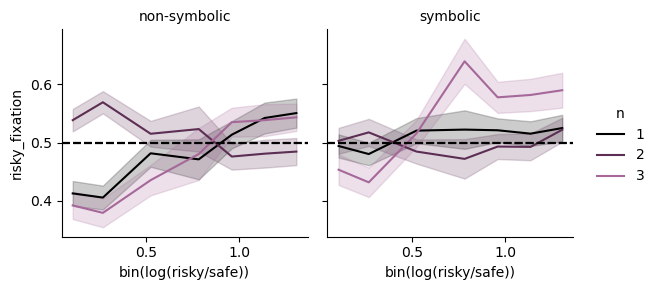

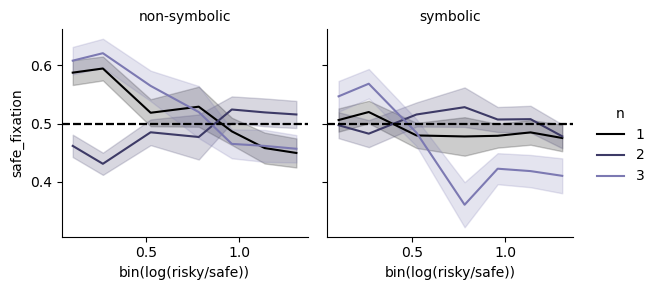

In [268]:
tmp = saccades.groupby(['subject', 'bin(log(risky/safe))', 'n', 'exptype']).mean()
tmp = tmp[~tmp.isnull().any(1)]

palette = sns.cubehelix_palette(start=.5, rot=0, dark=0, light=.5, n_colors=3, reverse=True)

g = sns.FacetGrid(tmp.query('(n < 4)').reset_index(), col='exptype', hue='n', palette=palette)#, palette='coolwarm')
g.map(sns.lineplot, 'bin(log(risky/safe))', 'risky_fixation', errorbar='se')
g.add_legend()
g.set_titles('{col_name}')
g.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))

palette = sns.cubehelix_palette(start=0, rot=0, dark=0, light=.5, n_colors=3, reverse=True)
g = sns.FacetGrid(tmp.query('(n < 4)').reset_index(), col='exptype', hue='n', palette=palette)#, palette='coolwarm')
g.map(sns.lineplot, 'bin(log(risky/safe))', 'safe_fixation', errorbar='se')
g.add_legend()
g.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))
g.set_titles('{col_name}')

In [282]:
last_fixations = saccades.groupby(['subject', 'exptype', 'run', 'block', 'trial']).apply(lambda d: d.reset_index('n').iloc[-1])

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83412/3910912719.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = last_fixations.groupby(['subject', 'bin(EV_risky)', 'exptype']).mean()
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83412/3910912719.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  tmp = tmp[~tmp.isnull().any(1)]
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83412/3910912719.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = last_fixations.groupby(['subject', 'EV_safe',

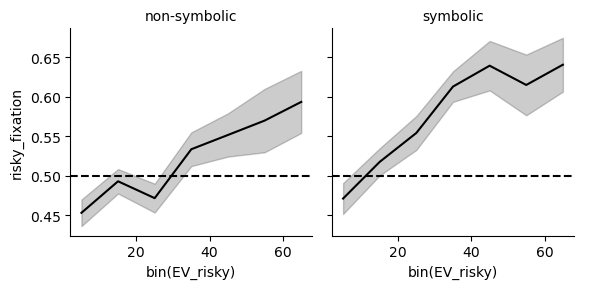

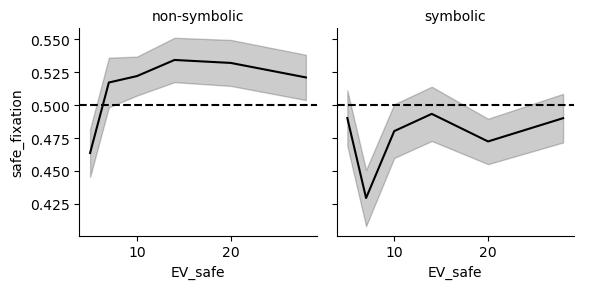

In [287]:
tmp = last_fixations.groupby(['subject', 'bin(EV_risky)', 'exptype']).mean()
tmp = tmp[~tmp.isnull().any(1)]


g = sns.FacetGrid(tmp.reset_index(), col='exptype')#, palette='coolwarm')
g.map(sns.lineplot, 'bin(EV_risky)', 'risky_fixation', errorbar='se', color='k')
g.add_legend()
g.set_titles('{col_name}')
g.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))


tmp = last_fixations.groupby(['subject', 'EV_safe', 'exptype']).mean()
g = sns.FacetGrid(tmp.reset_index(), col='exptype')#, palette='coolwarm')
g.map(sns.lineplot, 'EV_safe', 'safe_fixation', errorbar='se', color='k')
g.add_legend()
g.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))
g.set_titles('{col_name}')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83412/2532038199.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = last_fixations.groupby(['subject', 'bin(log(risky/safe))', 'exptype']).mean()
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83412/2532038199.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = last_fixations.groupby(['subject', 'bin(log(risky/safe))', 'exptype', 'n_safe']).mean()


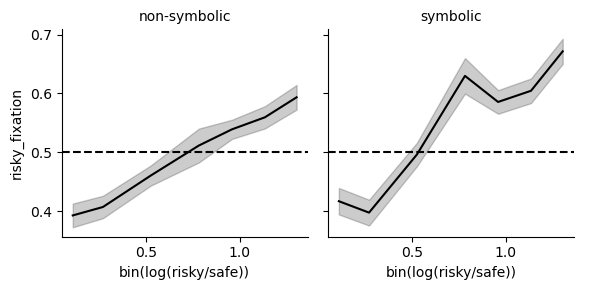

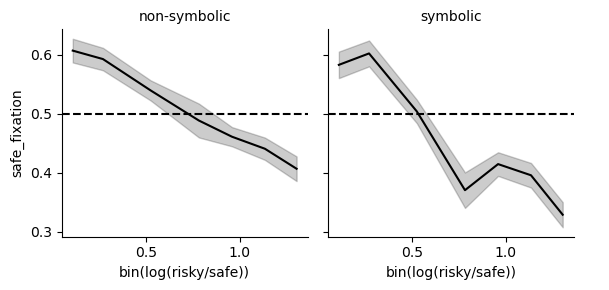

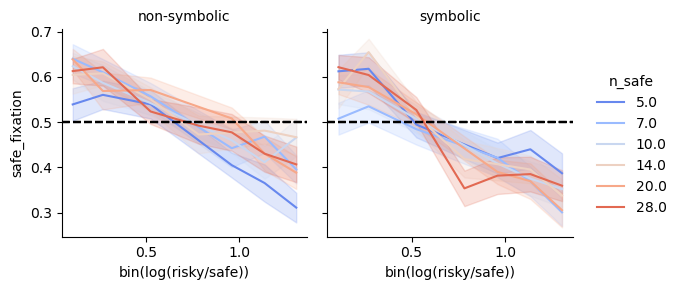

In [290]:
tmp = last_fixations.groupby(['subject', 'bin(log(risky/safe))', 'exptype']).mean()

g = sns.FacetGrid(tmp.reset_index(), col='exptype', palette=palette)#, palette='coolwarm')
g.map(sns.lineplot, 'bin(log(risky/safe))', 'risky_fixation', errorbar='se', color='k')
g.add_legend()
g.set_titles('{col_name}')
g.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))

g = sns.FacetGrid(tmp.reset_index(), col='exptype', palette=palette)#, palette='coolwarm')
g.map(sns.lineplot, 'bin(log(risky/safe))', 'safe_fixation', errorbar='se', color='k')
g.add_legend()
g.set_titles('{col_name}')
g.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))


tmp = last_fixations.groupby(['subject', 'bin(log(risky/safe))', 'exptype', 'n_safe']).mean()
g = sns.FacetGrid(tmp.reset_index(), col='exptype', hue='n_safe', palette='coolwarm')#, palette='coolwarm')
g.map(sns.lineplot, 'bin(log(risky/safe))', 'safe_fixation', errorbar='se')
g.add_legend()
g.set_titles('{col_name}')
g.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))
# tmp = last_fixations.groupby(['subject', 'EV_safe', 'exptype']).mean()
# palette = sns.cubehelix_palette(start=0, rot=0, dark=0, light=.5, n_colors=3, reverse=True)
# g = sns.FacetGrid(tmp.query('(n < 4)').reset_index(), col='exptype', palette=palette)#, palette='coolwarm')
# g.map(sns.lineplot, 'EV_safe', 'safe_fixation', errorbar='se')
# g.add_legend()
# g.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))
# g.set_titles('{col_name}')

In [320]:
saccades['duration'].clip(0, 1000, inplace=True)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83412/2725817754.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = saccades.groupby(['subject', 'bin(EV_risky)', 'n', 'exptype']).mean()
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83412/2725817754.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  tmp = tmp[~tmp.isnull().any(1)]
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83412/2725817754.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = saccades.groupby(['subject', 'EV_safe', 'n', '

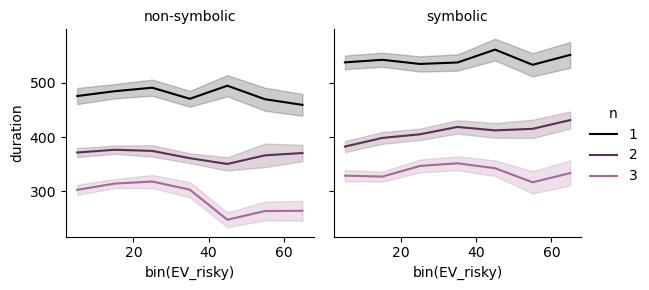

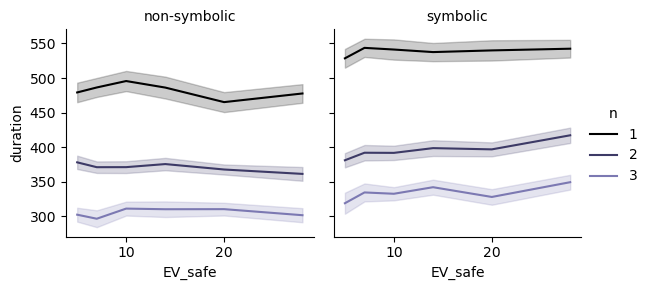

In [321]:
tmp = saccades.groupby(['subject', 'bin(EV_risky)', 'n', 'exptype']).mean()
tmp = tmp[~tmp.isnull().any(1)]

palette = sns.cubehelix_palette(start=.5, rot=0, dark=0, light=.5, n_colors=3, reverse=True)

g = sns.FacetGrid(tmp.query('(n < 4)').reset_index(), col='exptype', hue='n', palette=palette)#, palette='coolwarm')
g.map(sns.lineplot, 'bin(EV_risky)', 'duration', errorbar='se')
g.add_legend()
g.set_titles('{col_name}')

tmp = saccades.groupby(['subject', 'EV_safe', 'n', 'exptype']).mean()
palette = sns.cubehelix_palette(start=0, rot=0, dark=0, light=.5, n_colors=3, reverse=True)
g = sns.FacetGrid(tmp.query('(n < 4)').reset_index(), col='exptype', hue='n', palette=palette)#, palette='coolwarm')
g.map(sns.lineplot, 'EV_safe', 'duration', errorbar='se')
g.add_legend()
g.set_titles('{col_name}')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83412/2199914215.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = saccades.groupby(['subject', 'bin(log(risky/safe))', 'n', 'exptype']).mean()
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83412/2199914215.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  tmp = tmp[~tmp.isnull().any(1)]
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83412/2199914215.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = saccades.groupby(['subject', 'bin(log(r

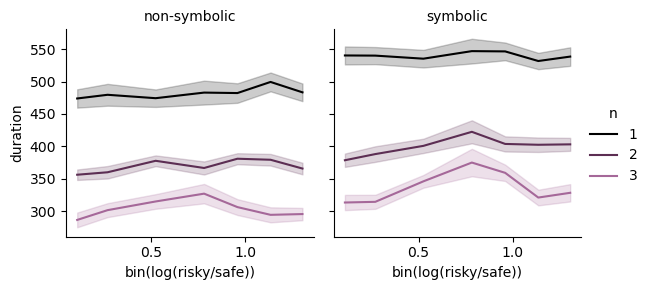

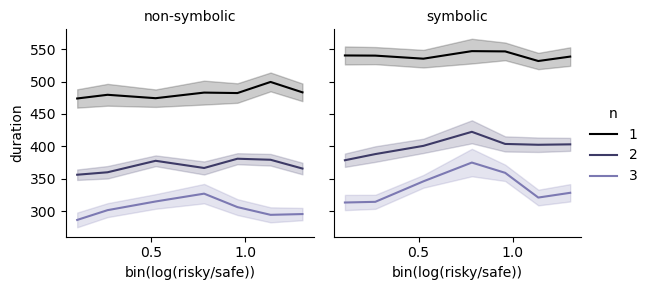

In [323]:
tmp = saccades.groupby(['subject', 'bin(log(risky/safe))', 'n', 'exptype']).mean()
tmp = tmp[~tmp.isnull().any(1)]

palette = sns.cubehelix_palette(start=.5, rot=0, dark=0, light=.5, n_colors=3, reverse=True)

g = sns.FacetGrid(tmp.query('(n < 4)').reset_index(), col='exptype', hue='n', palette=palette)#, palette='coolwarm')
g.map(sns.lineplot, 'bin(log(risky/safe))', 'duration', errorbar='se')
g.add_legend()
g.set_titles('{col_name}')

tmp = saccades.groupby(['subject', 'bin(log(risky/safe))', 'n', 'exptype']).mean()
palette = sns.cubehelix_palette(start=0, rot=0, dark=0, light=.5, n_colors=3, reverse=True)
g = sns.FacetGrid(tmp.query('(n < 4)').reset_index(), col='exptype', hue='n', palette=palette)#, palette='coolwarm')
g.map(sns.lineplot, 'bin(log(risky/safe))', 'duration', errorbar='se')
g.add_legend()
g.set_titles('{col_name}')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83412/3683706464.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = last_fixations.groupby(['subject', 'bin(EV_risky)', 'exptype']).mean()
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83412/3683706464.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  tmp = tmp[~tmp.isnull().any(1)]
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83412/3683706464.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = last_fixations.groupby(['subject', 'EV_safe',

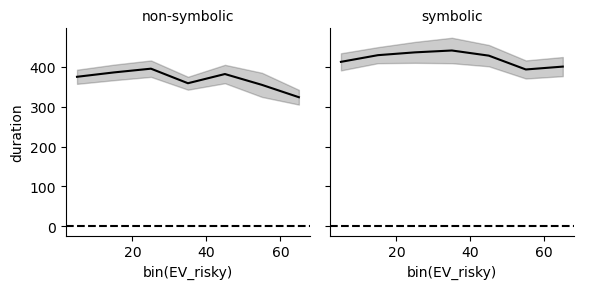

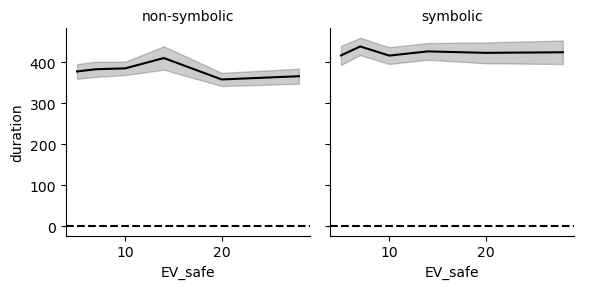

In [324]:
tmp = last_fixations.groupby(['subject', 'bin(EV_risky)', 'exptype']).mean()
tmp = tmp[~tmp.isnull().any(1)]


g = sns.FacetGrid(tmp.reset_index(), col='exptype')#, palette='coolwarm')
g.map(sns.lineplot, 'bin(EV_risky)', 'duration', errorbar='se', color='k')
g.add_legend()
g.set_titles('{col_name}')
g.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))


tmp = last_fixations.groupby(['subject', 'EV_safe', 'exptype']).mean()
g = sns.FacetGrid(tmp.reset_index(), col='exptype')#, palette='coolwarm')
g.map(sns.lineplot, 'EV_safe', 'duration', errorbar='se', color='k')
g.add_legend()
g.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))
g.set_titles('{col_name}')

# Proportional dwell time

In [292]:
eyepos = get_all_eyepos_info()

In [295]:
eyepos = eyepos.join(df)

In [299]:
eyepos['risky_dwelltime'] = eyepos['left_duration'].where(eyepos['p_left'] == 0.55, eyepos['right_duration'])
eyepos['safe_dwelltime'] = eyepos['left_duration'].where(eyepos['p_left'] == 1.0, eyepos['right_duration'])
eyepos['fixation_duration'] = eyepos['risky_dwelltime'] + eyepos['safe_dwelltime']

eyepos['risky_dwelltime_prop'] = eyepos['risky_dwelltime'] / eyepos['fixation_duration']
eyepos['safe_dwelltime_prop'] = eyepos['risky_dwelltime'] / eyepos['fixation_duration']

In [307]:
eyepos['EV_risky'] = eyepos['EV_left'].where(eyepos['p_left'] == 0.55, eyepos['EV_right'])
eyepos['EV_safe'] = eyepos['EV_left'].where(eyepos['p_right'] == 0.55, eyepos['EV_right'])

In [308]:
eyepos['bin(EV_risky)'] = pd.cut(eyepos['EV_risky'], bins=np.arange(0, 120, 10))
eyepos['bin(EV_risky)'].cat.categories = [bin.mid for bin in eyepos['bin(EV_risky)'].cat.categories]

eyepos['bin(EV_safe)'] = pd.cut(eyepos['EV_safe'], bins=np.arange(0, 120, ))
eyepos['bin(EV_safe)'].cat.categories = [bin.mid for bin in eyepos['bin(EV_safe)'].cat.categories]

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83412/4003034342.py:2: FutureWarning: Setting categories in-place is deprecated and will raise in a future version. Use rename_categories instead.
  eyepos['bin(EV_risky)'].cat.categories = [bin.mid for bin in eyepos['bin(EV_risky)'].cat.categories]
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_83412/4003034342.py:5: FutureWarning: Setting categories in-place is deprecated and will raise in a future version. Use rename_categories instead.
  eyepos['bin(EV_safe)'].cat.categories = [bin.mid for bin in eyepos['bin(EV_safe)'].cat.categories]


In [309]:
eyepos

n_saccades first_saccade  last_saccade  \
subject run block trial exptype                                            
01      1   1     1     symbolic           6   left_option   left_option   
                  2     symbolic           3  right_option  right_option   
                  3     symbolic           2   left_option  right_option   
                  4     symbolic           1  right_option  right_option   
                  5     symbolic           1  right_option  right_option   
...                                      ...           ...           ...   
64      5   4     20    symbolic           2  right_option   left_option   
                  21    symbolic           3   left_option   left_option   
                  22    symbolic           3   left_option  right_option   
                  23    symbolic           2   left_option  right_option   
                  24    symbolic           3   left_option   left_option   

                                  left_duration  right_duration  accuracy  \
subject run block trial exptype                                             
01      1   1     1     symbolic         1024.0           462.0       1.0   
                  2     symbolic          204.0           478.0       1.0   
                  3     symbolic          168.0           232.0       1.0   
                  4     symbolic            0.0           282.0       1.0   
                  5     symbolic            0.0           358.0       1.0   
...                                         ...             ...       ...   
64      5   4     20    symbolic          156.0           264.0       1.0   
                  21    symbolic          382.0           196.0       0.0   
                  22    symbolic          872.0           246.0       0.0   
                  23    symbolic          170.0           378.0       0.0   
                  24    symbolic         1050.0           374.0       1.0   

                                     rt  leftRight  pressedKey  n_safe  ...  \
subject run block trial exptype                                         ...   
01      1   1     1     symbolic  1.215        1.0        75.0    14.0  ...   
                  2     symbolic  0.737       -1.0        77.0     5.0  ...   
                  3     symbolic  0.920       -1.0        77.0    14.0  ...   
                  4     symbolic  0.965       -1.0        77.0    10.0  ...   
                  5     symbolic  1.218        1.0        75.0    14.0  ...   
...                                 ...        ...         ...     ...  ...   
64      5   4     20    symbolic  1.046       -1.0        77.0    28.0  ...   
                  21    symbolic  0.840        1.0        75.0    20.0  ...   
                  22    symbolic  0.671        1.0        75.0    10.0  ...   
                  23    symbolic  0.774        1.0        75.0    20.0  ...   
                  24    symbolic  0.874        1.0        75.0    28.0  ...   

                                  EV_right  risky_dwelltime  safe_dwelltime  \
subject run block trial exptype                                               
01      1   1     1     symbolic     14.00           1024.0           462.0   
                  2     symbolic      5.00            204.0           478.0   
                  3     symbolic     14.00            168.0           232.0   
                  4     symbolic     10.00              0.0           282.0   
                  5     symbolic     14.00              0.0           358.0   
...                                    ...              ...             ...   
64      5   4     20    symbolic     43.45            264.0           156.0   
                  21    symbolic     31.35            196.0           382.0   
                  22    symbolic     11.00            246.0           872.0   
                  23    symbolic     22.00            378.0           170.0   
                  24    symbolic     15.95            374.0        